## ***this notebook regards feature engineering testing and a gradient boosting baseline solution pipeline***

#### **imports**

In [20]:
import sys
import os

current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)

In [21]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import train
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from utils.evaluation import label_evaluation
from data_factory.DataLoader import DataLoader

#### **hyperparameters and constants**

In [22]:
delay = 7
result_file = '../data/predict.csv'
truth_file = '../data/ground_truth.hdf'

In [23]:
MA_MIN = 5
MA_MAX = 100
MA_STEP = 5
TRAIN_VALID_SIZE = 0.9
RANDOM_SEED = 0
EARLY_STOP = 20

#### **load data**

In [29]:
dl = DataLoader(config_file="../config/config.yml", use_previous_files=False, train_val_split=TRAIN_VALID_SIZE)

INFO:data_factory.DataLoader:../data/train.csv loaded. shape (2476315, 4)
INFO:data_factory.DataLoader:../data/test.csv loaded. shape (2345211, 3)
c:\Users\altf\Documents\Tsinghua University\Spring\Advanced Network Management\Project\kpi-anomaly-detection\data_factory\preprocessing.py:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  date_to_timestamp = {
INFO:data_factory.DataLoader:Preprocessing done.
INFO:data_factory.DataLoader:Data exported to "../data/data_export_train.csv_test.csv_fmd-True_s-True.p"


#### **feature engineering**

In [30]:
moving_avg_lens = [ma for ma in range(MA_MIN, MA_MAX+MA_STEP, MA_STEP)]

for dataset in (dl.train, dl.val, dl.test):
    for length in moving_avg_lens:
        # moving average
        dataset[f'MA{length}'] = dataset.groupby('kpi_id')['value_scaled'].transform(lambda x: x.rolling(window=length, min_periods=1).mean())
        dataset[f'DIFF_MA{length}'] = abs(dataset[f'MA{length}'] - dataset['value_scaled'])
        # exponential moving average
        dataset[f'EMA{length}'] = dataset.groupby('kpi_id')['value_scaled'].transform(lambda x: x.ewm(span=length, min_periods=1).mean())
        dataset[f'DIFF_EMA{length}'] = abs(dataset[f'EMA{length}'] - dataset['value_scaled'])
    # cumulative moving average
    dataset['CMA'] = dataset.groupby('kpi_id')['value_scaled'].transform(lambda x: x.expanding().mean())
    dataset['DIFF_CMA'] = abs(dataset['CMA'] - dataset['value_scaled'])
    
    # TODO ? how each datapoint deviates from the 'tipical value' for that time


<AxesSubplot:xlabel='timestamp'>

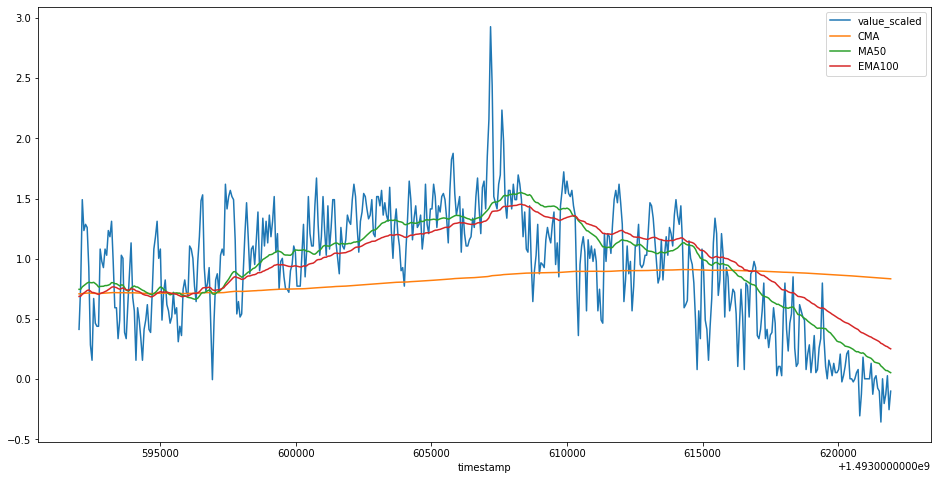

In [57]:
dl.train[dl.train['kpi_id'] == '02e99bd4f6cfb33f'].head(900)[400:].plot.line(x='timestamp', y=['value_scaled', 'CMA', 'MA50', 'EMA100'], figsize=(16, 8))

<AxesSubplot:xlabel='timestamp'>

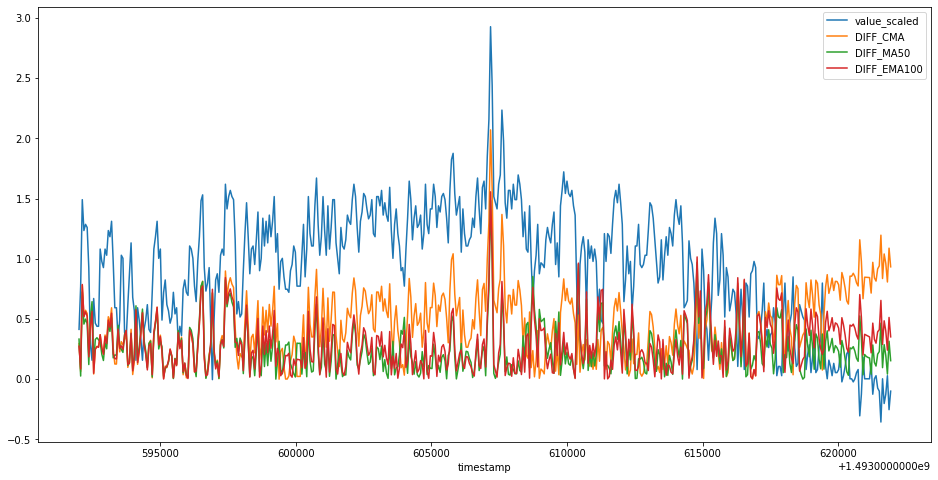

In [58]:
dl.train[dl.train['kpi_id'] == '02e99bd4f6cfb33f'].head(900)[400:].plot.line(x='timestamp', y=['value_scaled', 'DIFF_CMA', 'DIFF_MA50', 'DIFF_EMA100'], figsize=(16, 8))

In [7]:
c_ignored = ['timestamp', 'datetime', 'kpi_id', 'label']
X_train, y_train = dl.train.loc[:, [c for c in dl.train.columns if c not in c_ignored]], dl.train.loc[:, 'label']
X_val, y_val = dl.val.loc[:, [c for c in dl.val.columns if c not in c_ignored]], dl.val.loc[:, 'label']
X_test = dl.test.loc[:, [c for c in dl.test.columns if c not in c_ignored]]

##### **models**

In [8]:
model_params = {
    'max_depth': 7,
    'n_estimators': 100,
    'min_child_weight': 200,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eta': 0.04,
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'seed': RANDOM_SEED
}

model = XGBClassifier(**model_params)

#### **training**

In [9]:
fit_params = {
    'eval_metric': 'auc',
    'eval_set': [(X_train, y_train), (X_val, y_val)],
    'early_stopping_rounds': EARLY_STOP,
    'verbose': True
}

model.fit(X_train, y_train, **fit_params)

[0]	validation_0-auc:0.89938	validation_1-auc:0.87307
[1]	validation_0-auc:0.91985	validation_1-auc:0.92915
[2]	validation_0-auc:0.92154	validation_1-auc:0.93956
[3]	validation_0-auc:0.92160	validation_1-auc:0.94067
[4]	validation_0-auc:0.92583	validation_1-auc:0.93875
[5]	validation_0-auc:0.92458	validation_1-auc:0.93781
[6]	validation_0-auc:0.92987	validation_1-auc:0.93987
[7]	validation_0-auc:0.92887	validation_1-auc:0.94290
[8]	validation_0-auc:0.93055	validation_1-auc:0.94288
[9]	validation_0-auc:0.93071	validation_1-auc:0.94252
[10]	validation_0-auc:0.93078	validation_1-auc:0.94310
[11]	validation_0-auc:0.93262	validation_1-auc:0.94299
[12]	validation_0-auc:0.93432	validation_1-auc:0.94485
[13]	validation_0-auc:0.93489	validation_1-auc:0.94560
[14]	validation_0-auc:0.93564	validation_1-auc:0.94649
[15]	validation_0-auc:0.93570	validation_1-auc:0.94605
[16]	validation_0-auc:0.93639	validation_1-auc:0.94573
[17]	validation_0-auc:0.93790	validation_1-auc:0.94706
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.04, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0399999991, max_delta_step=0, max_depth=7,
              min_child_weight=200, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

#### **evaluation**

In [10]:
def evaluate(model, X, dataset, threshold, truth_file, result_file, delay):
    pred = model.predict_proba(X)[:,1]
    pred = np.where(pred > threshold, 1, 0)
    prediction = dataset.loc[:, ['timestamp', 'kpi_id']].rename(columns={'kpi_id': 'KPI ID'})
    prediction['predict'] = pred
    prediction.to_csv(result_file)

    ground_truth = dataset.loc[:, ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
    ground_truth.to_hdf(truth_file, key='df')

    return label_evaluation(truth_file, result_file, delay)

find best threshold

In [11]:
best = 0.
THRESHOLD = 0.
for t in range(0, 100):
    eval = json.loads(evaluate(model, X_val, dl.val, t / 100, truth_file, result_file, delay))
    if eval['data'] > best:
        THRESHOLD = t / 100
        best = eval['data']

In [12]:
print(f'{THRESHOLD = }')

THRESHOLD = 0.32


run evaluation

In [13]:
for name, X, dataset in (('train', X_train, dl.train), ('val', X_val, dl.val)):
    print(f'evaluating: {name}')
    print(evaluate(model, X, dataset, THRESHOLD, truth_file, result_file, delay))

evaluating: train
{"result": true, "data": 0.7669321362413295, "message": "计算成功"}
evaluating: val
{"result": true, "data": 0.8140171139181559, "message": "计算成功"}


#### **submission**

In [14]:
pred = model.predict_proba(X_test)[:,1]
pred = np.where(pred > THRESHOLD, 1, 0)
prediction = dl.test.loc[:, ['timestamp', 'kpi_id']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = pred
prediction.to_csv(result_file)